# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/datasets/ealaxi/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [7]:
# Your code here
finantial = pd.read_csv("PS_20174392719_1491204439457_log.csv")
finantial_samp = finantial.sample(100000)

In [4]:
finantial_samp.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1635083,157,PAYMENT,4742.58,C3673093,0.0,0.00,M1894780459,0.00,0.00,0,0
919804,43,CASH_OUT,6140.55,C749154626,0.0,0.00,C161392898,3985947.38,3992087.93,0,0
4319666,308,PAYMENT,9497.51,C1675562496,58681.0,49183.49,M1464366977,0.00,0.00,0,0
5797497,401,CASH_IN,96456.19,C461508864,1199763.4,1296219.59,C2116281134,101381.88,4925.69,0,0
3566187,260,PAYMENT,4601.19,C212271533,631.0,0.00,M1667099248,0.00,0.00,0,0


### What is the distribution of the outcome? 

0    99872
1      128
Name: isFraud, dtype: int64
0    100000
Name: isFlaggedFraud, dtype: int64


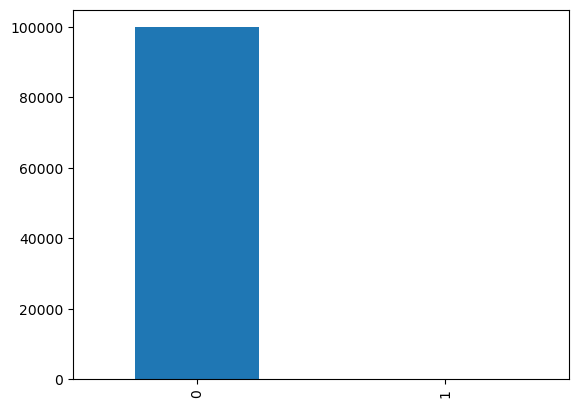

In [29]:
# Your response here
finantial_samp["isFraud"].value_counts().plot(kind="bar")
print(finantial_samp["isFraud"].value_counts())
print(finantial_samp["isFlaggedFraud"].value_counts())

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [9]:
# Your code here
finantial_samp.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [12]:
finantial_samp.dtypes
finantial_samp["type"].value_counts()
typecol = pd.get_dummies(finantial_samp["type"],prefix = "type")

In [13]:
finantial_samp = pd.concat([finantial_samp, typecol], axis=1, join='outer')
finantial_samp.drop(columns = "type", axis=1, inplace=True)

In [24]:
finantial_samp.drop(columns = ["nameDest","nameOrig"], axis=1, inplace=True)

In [30]:
finantial_samp.dtypes

step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
type_CASH_IN        uint8
type_CASH_OUT       uint8
type_DEBIT          uint8
type_PAYMENT        uint8
type_TRANSFER       uint8
dtype: object

C:\Users\pedro\AppData\Local\Temp\ipykernel_29080\2957104802.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


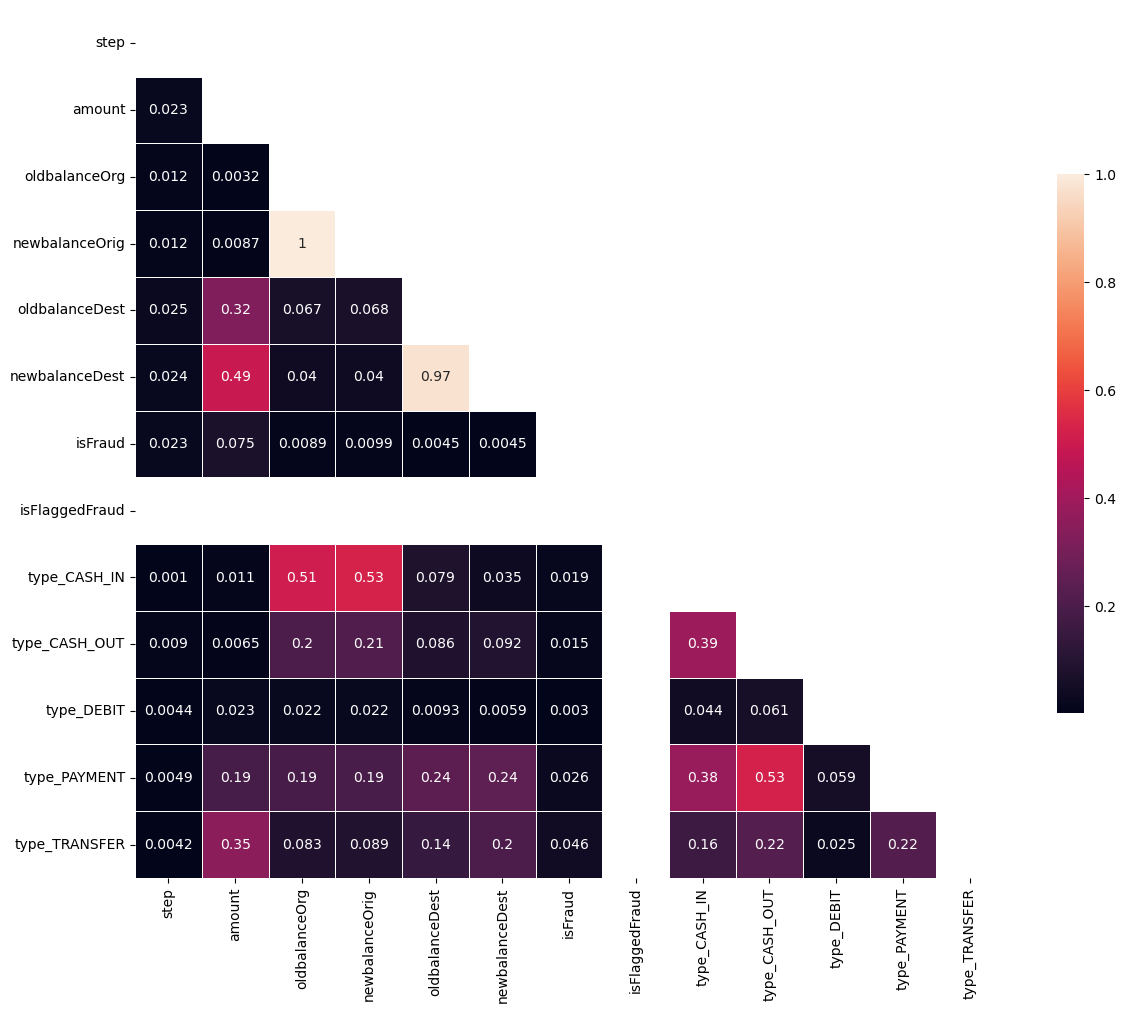

In [35]:
corr=np.abs(finantial_samp.corr())
#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))
# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)
plt.show()

### Run a logisitc regression classifier and evaluate its accuracy.

In [41]:
# Your code here
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
x_train, x_test, y_train, y_test = train_test_split(finantial_samp.drop(columns = "isFraud",axis=1), finantial_samp["isFraud"])

In [40]:
model = LogisticRegression(max_iter=10000)

model.fit(x_train,y_train)

# score
print("test data accuracy is", model.score(x_test, y_test))
print("train data accuracy is", model.score(x_train, y_train))

test data accuracy is 0.99844
train data accuracy is 0.9985066666666667


In [42]:
pred = model.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24972
           1       0.38      0.64      0.48        28

    accuracy                           1.00     25000
   macro avg       0.69      0.82      0.74     25000
weighted avg       1.00      1.00      1.00     25000



In [43]:
confusion_matrix(y_test, pred)

array([[24943,    29],
       [   10,    18]], dtype=int64)

### Now pick a model of your choice and evaluate its accuracy.

In [48]:
# lets try oversampling

train = pd.concat([x_train,y_train],axis=1)

no_fraud = train[train["isFraud"]==0]
yes_fraud = train[train["isFraud"]==1]

In [49]:
print(no_fraud.shape)
print(yes_fraud.shape)

(74900, 13)
(100, 13)


In [51]:
from sklearn.utils import resample 
yes_fraud_oversampled = resample(yes_fraud, replace=True,n_samples = len(no_fraud))

In [52]:
train_over = pd.concat([no_fraud, yes_fraud_oversampled])

In [54]:
x_train_over = train_over.drop("isFraud", axis=1)
y_train_over = train_over["isFraud"]

In [57]:
model.fit(x_train_over,y_train_over)

# score
print("test data accuracy is", model.score(x_test, y_test))
print("train data accuracy is", model.score(x_train_over, y_train_over))

test data accuracy is 0.98696
train data accuracy is 0.9935781041388518


In [56]:
pred = model.predict(x_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     24972
           1       0.08      1.00      0.15        28

    accuracy                           0.99     25000
   macro avg       0.54      0.99      0.57     25000
weighted avg       1.00      0.99      0.99     25000

[[24646   326]
 [    0    28]]


In [60]:
# Your code here
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=3)

tree.fit(x_train,y_train)
print("test data accuracy is", tree.score(x_test, y_test))
print("train data accuracy is", tree.score(x_train, y_train))

test data accuracy is 0.99896
train data accuracy is 0.9989733333333334


In [61]:
pred = tree.predict(x_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24972
           1       1.00      0.07      0.13        28

    accuracy                           1.00     25000
   macro avg       1.00      0.54      0.57     25000
weighted avg       1.00      1.00      1.00     25000

[[24972     0]
 [   26     2]]


In [58]:
tree = DecisionTreeClassifier(max_depth=3)

tree.fit(x_train_over,y_train_over)
print("test data accuracy is", tree.score(x_test, y_test))
print("train data accuracy is", tree.score(x_train_over, y_train_over))

test data accuracy is 0.97248
train data accuracy is 0.9601268357810414


In [59]:
pred = tree.predict(x_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     24972
           1       0.04      0.96      0.07        28

    accuracy                           0.97     25000
   macro avg       0.52      0.97      0.53     25000
weighted avg       1.00      0.97      0.99     25000

[[24285   687]
 [    1    27]]


### Which model worked better and how do you know?

In [2]:
# Your response here
"""
I believe the logistic regression model (after oversampling) worked better since the it managed to have zero false negatives
this means we managed to catch all fraudulent transactions
even though we had more cases reported as fraud which turned out to not be, in this case
its better to flag and realize its not true then to not flag and let a fraudulent transactionpass through
"""

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.